In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from scipy.special import gamma
from scipy.special import gammaln
from scipy.optimize import differential_evolution

from tqdm import tqdm
from matplotlib.backends.backend_pdf import PdfPages

In [27]:
from functions import compute_r, rho_model, log_rho_model

plt.style.use('ggplot')

In [161]:
coordinates_df = pd.read_csv('../data/coordinates.csv')

n_events = 100

X = coordinates_df['X']
Y = coordinates_df['Y']
Z = coordinates_df['Z']


Ne, s = 1e6, 1.2
theta, phi = 30, 210
Z0 = - 18
X0_array = np.random.uniform(-40, 40, size=n_events)
Y0_array = np.random.uniform(-70, 70, size=n_events)

bounds = [
    (-50, 50),  # X0
    (-80, 80),  # Y0
    (1, 1e8),  # Ne
    (0.2, 2)  # s
]

In [53]:
def loss_function(params, coordinates_df, rho, theta, phi, Z0):
    X0, Y0, Ne, s = params
    r = compute_r(X0, Y0, Z0, theta, phi, coordinates_df)
    rho_calc = rho_model(r, Ne, s)
    # return np.mean((rho_calc - rho) ** 2)
    return np.mean((np.log(rho_calc) - np.log(rho)) ** 2)

In [ ]:
def find_paramns(coordinates, theta, phi, X0_array, Y0_array, Z0, Ne, s):
    r_list, rho_list = [], []
    X0_list, Y0_list = [], []
    Ne_list, s_list = [], []

    for i in tqdm(range(n_events), desc="Processing events"):
        X0, Y0 = X0_array[i], Y0_array[i]

        r = compute_r(X0, Y0, Z0, theta, phi, coordinates)
        rho = rho_model(r, Ne, s)

        result = differential_evolution(
            loss_function,
            bounds,
            args=(coordinates, rho, theta, phi, Z0)
        )
        X0_opt, Y0_opt, Ne_opt, s_opt = result.x

        r_list.append(r)
        rho_list.append(rho)
        X0_list.append(X0_opt)
        Y0_list.append(Y0_opt)
        Ne_list.append(Ne_opt)
        s_list.append(s_opt)

    return (
        np.array(r_list),
        np.array(rho_list),
        np.array(X0_list),
        np.array(Y0_list),
        np.array(Ne_list),
        np.array(s_list)
    )

In [163]:
r_array, rho_array, X0_opt_array, Y0_opt_array, Ne_opt_array, s_opt_array = find_paramns(
    coordinates_df, theta, phi, X0_array, Y0_array, Z0, Ne, s)

Processing events:   1%|          | 1/100 [00:14<24:07, 14.62s/it]


KeyboardInterrupt: 

In [118]:
delta_X0 = X0_opt_array - X0_array
delta_Y0 = Y0_opt_array - Y0_array
delta_Ne = (Ne_opt_array - Ne) / Ne
delta_s = (s_opt_array - s) / s

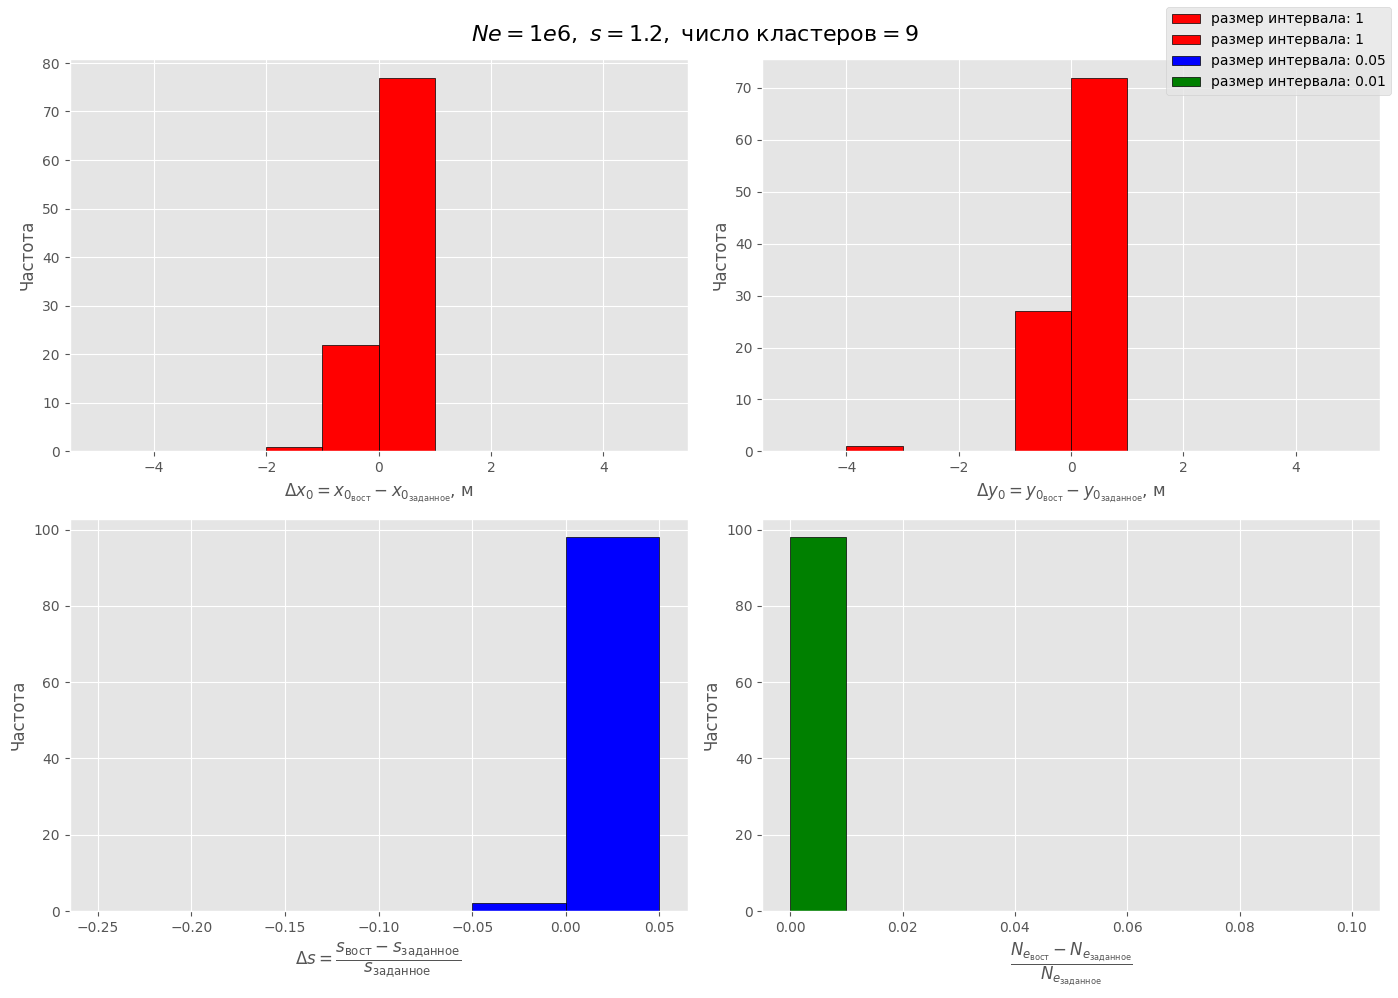

In [119]:
interval_delta_X = 1
interval_delta_Y = 1

interval_delta_s = 0.05
interval_delta_Ne = 0.01

bin_edges_delta_X = np.arange(-5, 6, interval_delta_X)
bin_edges_delta_Y = np.arange(-5, 6, interval_delta_Y)

bin_edges_delta_s = np.arange(-0.25, 0.1, interval_delta_s)
bin_edges_delta_Ne = np.arange(0, 0.11, interval_delta_Ne)


fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(r'$Ne=1e6,~ s=1.2,~ \text{число кластеров} = 9$', fontsize=16)
# delta_X
axes[0, 0].hist(delta_X0, bins=bin_edges_delta_X,
                edgecolor='black', color='red', label=f'размер интервала: {interval_delta_X}')
axes[0, 0].set_xlabel(
    r'$\Delta x_0 = x_{0_{\text{вост}}} - x_{0_{\text{заданное}}}$, м')
axes[0, 0].set_ylabel("Частота")

# delta_Y
axes[0, 1].hist(delta_Y0, bins=bin_edges_delta_Y,
                edgecolor='black', color='red', label=f'размер интервала: {interval_delta_Y}')
axes[0, 1].set_xlabel(
    r'$\Delta y_0 = y_{0_{\text{вост}}} - y_{0_{\text{заданное}}}$, м')
axes[0, 1].set_ylabel("Частота")

# delta_s
axes[1, 0].hist(delta_s, bins=bin_edges_delta_s, edgecolor='black',
                color='blue', label=f'размер интервала: {interval_delta_s}')
axes[1, 0].set_xlabel(
    r'$\Delta s = \dfrac{s_{\text{вост}} - s_{\text{заданное}}}{s_{\text{заданное}}}$')
axes[1, 0].set_ylabel("Частота")

# delta_Ne
axes[1, 1].hist(delta_Ne, bins=bin_edges_delta_Ne,
                edgecolor='black', color='green', label=f'размер интервала: {interval_delta_Ne}')
axes[1, 1].set_xlabel(
    r'$\dfrac{N_{e_{\text{вост}}} - N_{e_{\text{заданное}}}}{N_{e_{\text{заданное}}}}$')
axes[1, 1].set_ylabel("Частота")

fig.legend()

# data = pd.DataFrame(
#     {'delta_r': np.array(delta_r).reshape(-1, 36).tolist, 'delta_s': delta_s, 'delta_Ne': delta_Ne})
# data.to_csv(f'plots/{model_number}/delta_r,s,Ne.csv', index=False)

plt.tight_layout()
plt.savefig(f'plots_testing/delta_r,s_12,Ne_1e6,clasters_9.png',
            dpi=500, bbox_inches="tight")
plt.show()

In [233]:
def add_noise(rho, noise_level=0.1):
    """Добавляет гауссов шум к значениям rho"""
    noise = np.random.normal(loc=0, scale=noise_level *
                             np.abs(rho), size=rho.shape)
    return rho + noise

In [201]:
def find_paramns(coordinates, theta, phi, X0_array, Y0_array, Z0, Ne, s, n_clusters=9):
    r_list, rho_list = [], []
    X0_list, Y0_list = [], []
    Ne_list, s_list = [], []
    used_clusters_list = []
    rho_noisy_list = []

    unique_clusters = coordinates['cluster'].unique()

    for i in tqdm(range(n_events), desc="Processing events"):
        selected_clusters = np.random.choice(
            unique_clusters, size=n_clusters, replace=False)
        used_clusters_list.append(selected_clusters)
        mask = coordinates['cluster'].isin(selected_clusters)
        selected_coords = coordinates[mask]

        X0, Y0 = X0_array[i], Y0_array[i]

        r = compute_r(X0, Y0, Z0, theta, phi, selected_coords)
        rho = rho_model(r, Ne, s)
        rho_noisy = add_noise(rho, noise_level=0.20)

        # Оптимизация параметров
        result = differential_evolution(
            loss_function,
            bounds,
            args=(selected_coords, rho_noisy, theta, phi, Z0)
        )
        X0_opt, Y0_opt, Ne_opt, s_opt = result.x

        r_list.append(r)
        rho_list.append(rho)
        rho_noisy_list.append(rho_noisy)

        X0_list.append(X0_opt)
        Y0_list.append(Y0_opt)
        Ne_list.append(Ne_opt)
        s_list.append(s_opt)

    return (
        np.array(r_list),
        np.array(rho_list),
        np.array(X0_list),
        np.array(Y0_list),
        np.array(Ne_list),
        np.array(s_list),
        np.array(used_clusters_list),
        np.array(rho_noisy_list)
    )

In [202]:
r_array, rho_array, X0_opt_array, Y0_opt_array, Ne_opt_array, s_opt_array, used_clusters_array, rho_noisy_array = find_paramns(
    coordinates_df, theta, phi, X0_array, Y0_array, Z0, Ne, s, n_clusters=5)

Processing events: 100%|██████████| 100/100 [02:09<00:00,  1.29s/it]


In [204]:
delta_X0 = X0_opt_array - X0_array
delta_Y0 = Y0_opt_array - Y0_array
delta_Ne = (Ne_opt_array - Ne) / Ne
delta_s = (s_opt_array - s) / s

In [205]:
Ne, s,

(1000000.0, 1.2)

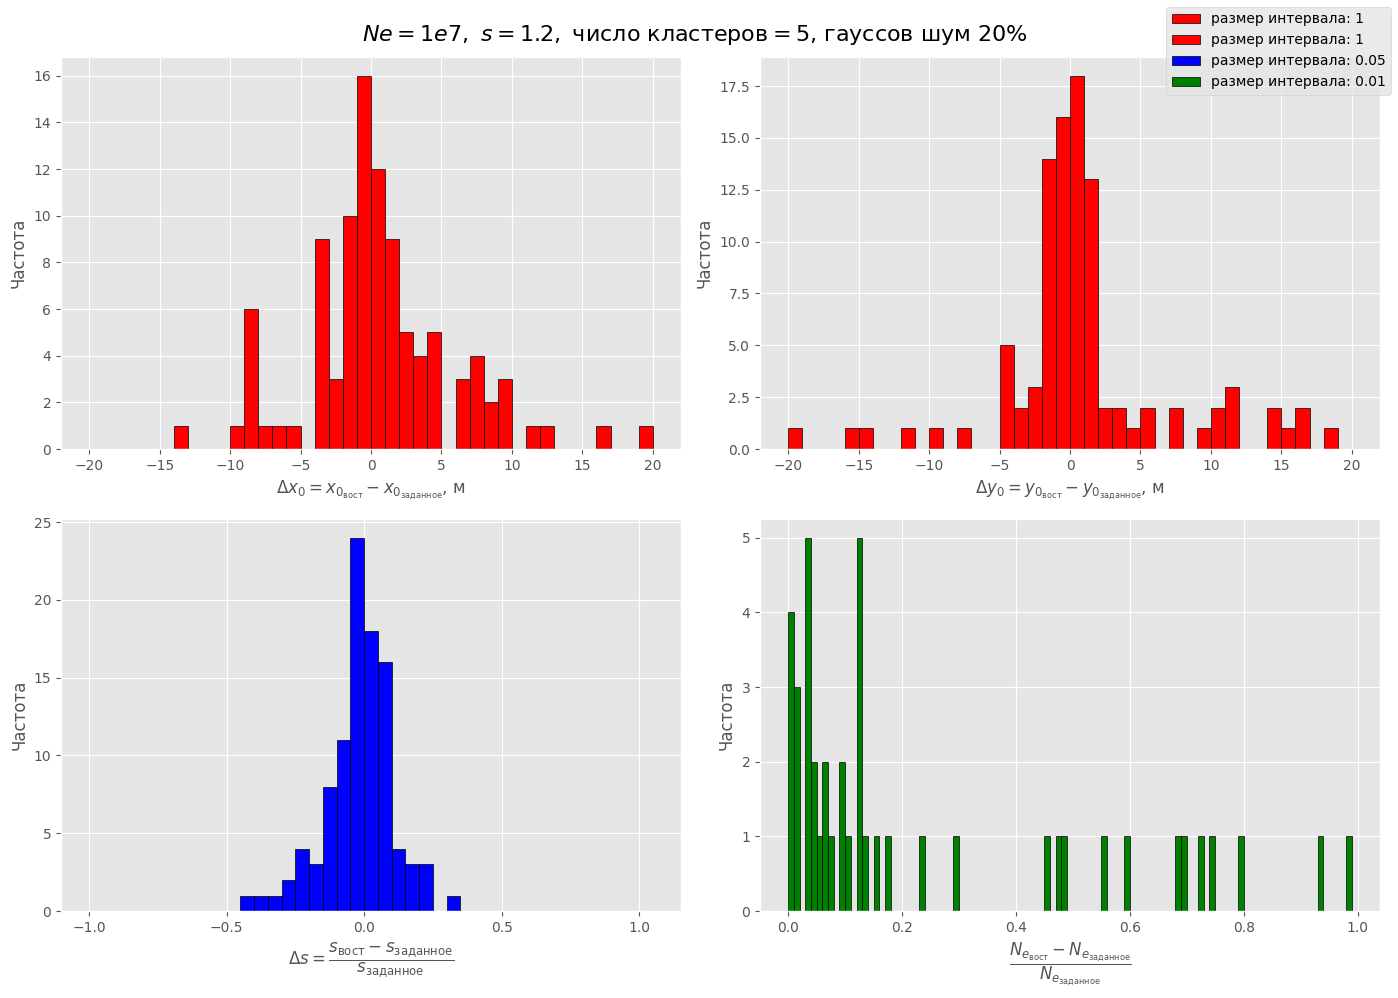

In [207]:
interval_delta_X = 1
interval_delta_Y = 1

interval_delta_s = 0.05
interval_delta_Ne = 0.01

bin_edges_delta_X = np.arange(-20, 21, interval_delta_X)
bin_edges_delta_Y = np.arange(-20, 21, interval_delta_Y)

bin_edges_delta_s = np.arange(-1, 1.1, interval_delta_s)
bin_edges_delta_Ne = np.arange(0, 1, interval_delta_Ne)


fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(
    r'$Ne=1e7,~ s=1.2,~ \text{число кластеров} = 5$, гауссов шум 20%', fontsize=16)
# delta_X
axes[0, 0].hist(delta_X0, bins=bin_edges_delta_X,
                edgecolor='black', color='red', label=f'размер интервала: {interval_delta_X}')
axes[0, 0].set_xlabel(
    r'$\Delta x_0 = x_{0_{\text{вост}}} - x_{0_{\text{заданное}}}$, м')
axes[0, 0].set_ylabel("Частота")

# delta_Y
axes[0, 1].hist(delta_Y0, bins=bin_edges_delta_Y,
                edgecolor='black', color='red', label=f'размер интервала: {interval_delta_Y}')
axes[0, 1].set_xlabel(
    r'$\Delta y_0 = y_{0_{\text{вост}}} - y_{0_{\text{заданное}}}$, м')
axes[0, 1].set_ylabel("Частота")

# delta_s
axes[1, 0].hist(delta_s, bins=bin_edges_delta_s, edgecolor='black',
                color='blue', label=f'размер интервала: {interval_delta_s}')
axes[1, 0].set_xlabel(
    r'$\Delta s = \dfrac{s_{\text{вост}} - s_{\text{заданное}}}{s_{\text{заданное}}}$')
axes[1, 0].set_ylabel("Частота")

# delta_Ne
axes[1, 1].hist(delta_Ne, bins=bin_edges_delta_Ne,
                edgecolor='black', color='green', label=f'размер интервала: {interval_delta_Ne}')
axes[1, 1].set_xlabel(
    r'$\dfrac{N_{e_{\text{вост}}} - N_{e_{\text{заданное}}}}{N_{e_{\text{заданное}}}}$')
axes[1, 1].set_ylabel("Частота")

fig.legend()

# data = pd.DataFrame(
#     {'delta_r': np.array(delta_r).reshape(-1, 36).tolist, 'delta_s': delta_s, 'delta_Ne': delta_Ne})
# data.to_csv(f'plots/{model_number}/delta_r,s,Ne.csv', index=False)

plt.tight_layout()
plt.savefig(fr'plots_testing/delta_r,s_1.2,Ne_1e7,clasters_5_noise20.png',
            dpi=500, bbox_inches="tight")
plt.show()

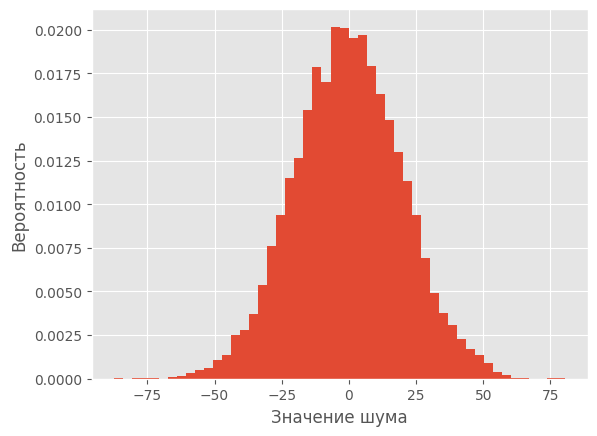

In [228]:
rho_i = 200.0
noise_level = 0.1
noise_samples = np.random.normal(0, noise_level * rho_i, size=10000)

plt.hist(noise_samples, bins=50, density=True)
plt.xlabel('Значение шума')
plt.ylabel('Вероятность')
plt.show()

In [230]:
x_coords = np.arange(-50, 51, 10)
y_coords = np.arange(-80, 81, 10)
z_coord = -18


xx, yy = np.meshgrid(x_coords, y_coords)

my_coordindates_df = pd.DataFrame({
    'X': xx.flatten(),
    'Y': yy.flatten(),
    'Z': z_coord
})


# Сортируем по Y, затем по X для удобства
my_coordindates_df = my_coordindates_df.sort_values(
    ['Y', 'X']).reset_index(drop=True)

print(f"Всего точек: {len(my_coordindates_df)}")

Всего точек: 187


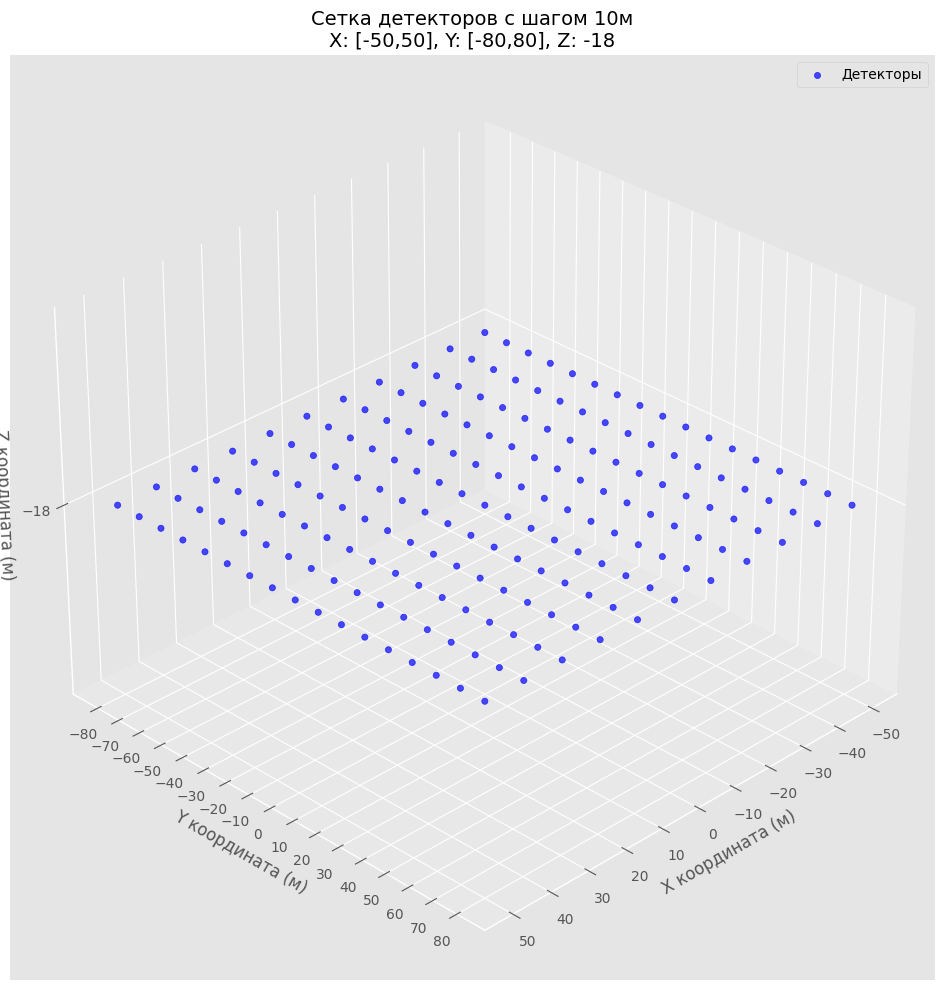

In [240]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Создаем 3D-график
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Визуализируем точки сетки
ax.scatter(my_coordindates_df['X'], my_coordindates_df['Y'], my_coordindates_df['Z'],
           c='blue', s=20, alpha=0.7, label='Детекторы')

# Настройка осей
ax.set_xlabel('X координата (м)', fontsize=12)
ax.set_ylabel('Y координата (м)', fontsize=12)
ax.set_zlabel('Z координата (м)', fontsize=12)
ax.set_title(
    'Сетка детекторов с шагом 10м\nX: [-50,50], Y: [-80,80], Z: -18', fontsize=14)

# Линии сетки
ax.set_xticks(np.arange(-50, 51, 10))
ax.set_yticks(np.arange(-80, 81, 10))
ax.set_zticks([-18])

# Дополнительные настройки
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend(fontsize=10)

# Угол обзора
ax.view_init(elev=30, azim=45)  # Изменяйте эти значения для разного ракурса

plt.tight_layout()
plt.show()

In [255]:
def find_my_paramns(coordinates, theta, phi, X0_array, Y0_array, Z0, Ne, s):
    r_list, rho_list = [], []
    X0_list, Y0_list = [], []
    Ne_list, s_list = [], []

    for i in tqdm(range(n_events), desc="Processing events"):
        X0, Y0 = X0_array[i], Y0_array[i]

        r = compute_r(X0, Y0, Z0, theta, phi, coordinates)
        rho = rho_model(r, Ne, s)
        rho_noisy = add_noise(rho, noise_level=0.40)

        result = differential_evolution(
            loss_function,
            bounds,
            args=(coordinates, rho_noisy, theta, phi, Z0)
        )
        X0_opt, Y0_opt, Ne_opt, s_opt = result.x

        r_list.append(r)
        rho_list.append(rho_noisy)
        X0_list.append(X0_opt)
        Y0_list.append(Y0_opt)
        Ne_list.append(Ne_opt)
        s_list.append(s_opt)

    return (
        np.array(r_list),
        np.array(rho_list),
        np.array(X0_list),
        np.array(Y0_list),
        np.array(Ne_list),
        np.array(s_list)
    )

In [256]:
r_array, rho_array, X0_opt_array, Y0_opt_array, Ne_opt_array, s_opt_array = find_my_paramns(
    my_coordindates_df, theta, phi, X0_array, Y0_array, Z0, Ne, s)

Processing events:   0%|          | 0/100 [00:00<?, ?it/s]C:\Users\matsvei\AppData\Local\Temp\ipykernel_5804\4056938729.py:6: RuntimeWarning: invalid value encountered in log
  return np.mean((np.log(rho_calc) - np.log(rho)) ** 2)
Processing events:   0%|          | 0/100 [00:14<?, ?it/s]


KeyboardInterrupt: 

In [257]:
delta_X0 = X0_opt_array - X0_array
delta_Y0 = Y0_opt_array - Y0_array
delta_Ne = (Ne_opt_array - Ne) / Ne
delta_s = (s_opt_array - s) / s

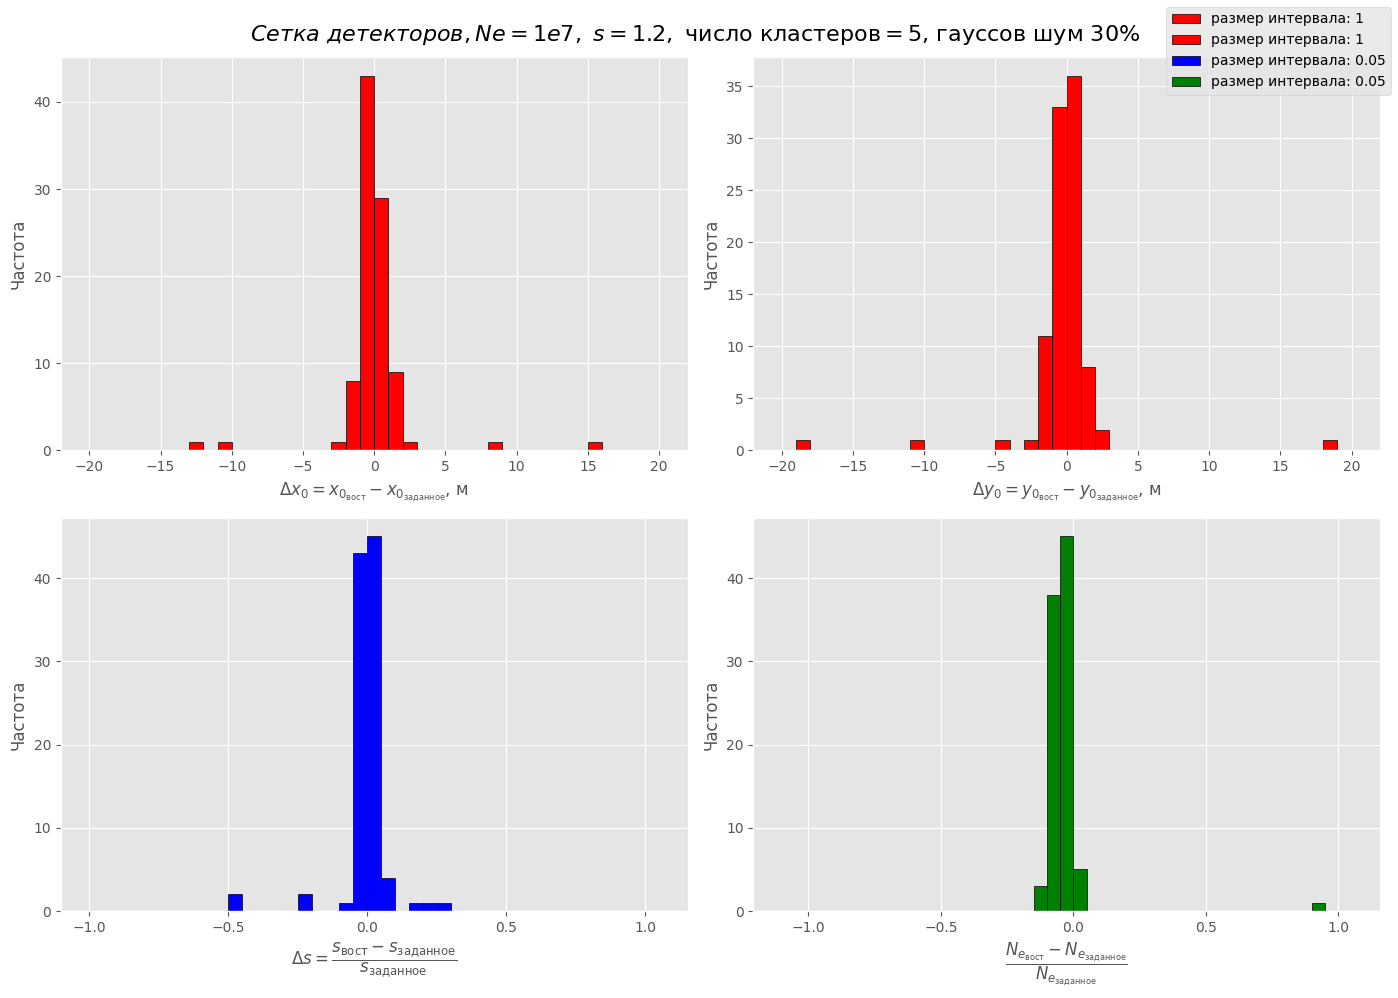

In [259]:
interval_delta_X = 1
interval_delta_Y = 1

interval_delta_s = 0.05
interval_delta_Ne = 0.05

bin_edges_delta_X = np.arange(-20, 21, interval_delta_X)
bin_edges_delta_Y = np.arange(-20, 21, interval_delta_Y)

bin_edges_delta_s = np.arange(-1, 1.1, interval_delta_s)
bin_edges_delta_Ne = np.arange(-1.1, 1.1, interval_delta_Ne)


fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(
    r'$Сетка~детекторов, Ne=1e7,~ s=1.2,~ \text{число кластеров} = 5$, гауссов шум 30%', fontsize=16)
# delta_X
axes[0, 0].hist(delta_X0, bins=bin_edges_delta_X,
                edgecolor='black', color='red', label=f'размер интервала: {interval_delta_X}')
axes[0, 0].set_xlabel(
    r'$\Delta x_0 = x_{0_{\text{вост}}} - x_{0_{\text{заданное}}}$, м')
axes[0, 0].set_ylabel("Частота")

# delta_Y
axes[0, 1].hist(delta_Y0, bins=bin_edges_delta_Y,
                edgecolor='black', color='red', label=f'размер интервала: {interval_delta_Y}')
axes[0, 1].set_xlabel(
    r'$\Delta y_0 = y_{0_{\text{вост}}} - y_{0_{\text{заданное}}}$, м')
axes[0, 1].set_ylabel("Частота")

# delta_s
axes[1, 0].hist(delta_s, bins=bin_edges_delta_s, edgecolor='black',
                color='blue', label=f'размер интервала: {interval_delta_s}')
axes[1, 0].set_xlabel(
    r'$\Delta s = \dfrac{s_{\text{вост}} - s_{\text{заданное}}}{s_{\text{заданное}}}$')
axes[1, 0].set_ylabel("Частота")

# delta_Ne
axes[1, 1].hist(delta_Ne, bins=bin_edges_delta_Ne,
                edgecolor='black', color='green', label=f'размер интервала: {interval_delta_Ne}')
axes[1, 1].set_xlabel(
    r'$\dfrac{N_{e_{\text{вост}}} - N_{e_{\text{заданное}}}}{N_{e_{\text{заданное}}}}$')
axes[1, 1].set_ylabel("Частота")

fig.legend()

# data = pd.DataFrame(
#     {'delta_r': np.array(delta_r).reshape(-1, 36).tolist, 'delta_s': delta_s, 'delta_Ne': delta_Ne})
# data.to_csv(f'plots/{model_number}/delta_r,s,Ne.csv', index=False)

plt.tight_layout()
plt.savefig(fr'plots_testing/my_grid/delta_r,s_1.2,Ne_1e7,noise30.png',
            dpi=500, bbox_inches="tight")
plt.show()